# Sentence Splitting
This notebook uses OCRed text for a volume year and splits it into sentences using regular expression pattern matching.<br>
For this notebook to run, there should be an OCRed folder that should contain a .txt file, a .tsv file, and an images sub-folder (more details in the notebook).

<b>Note:</b>
- If the Acts and Joints were mixed for the chosen year, the OCRed output will contain `{year}_Both.txt` and `{year}_Both_data.tsv`
- If the Acts and Joints were seperate for the chosen year, the OCRed output will contain `{year}_Acts.txt` and `{year}_Acts_data.tsv`

In [1]:
from nltk.tokenize import PunktSentenceTokenizer
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import re

pd.set_option('display.max_colwidth', None)

<br>
Either get the year variable from elsewhere (such as when this notebook is accessed from another file) or specify the year.

In [2]:
# Get the year variable from somewhere else
%store -r year

In [3]:
# # If running this notebook independently,
# # Uncoment the following line of code
# year = 1893

In [4]:
# This is the directory that will contain the OCRed output:
dir_OCR = "/Users/nitingupta/Desktop/OTB/OCRed/" + str(year)

print(f"Working on {year} under {dir_OCR}")

Working on 1894 under /Users/nitingupta/Desktop/OTB/OCRed/1894


In [5]:
# Try reading in "{year}_text.txt" if the Acts and Joints were seperate for the year
try:
    acts_path = dir_OCR + "/" + str(year) + "_Acts.txt"
    with open(acts_path, 'r') as f:
        data = f.read()

    # If the read is successful, set a flag that identifies that the Acts and Joints are seperate
    actsSep = True

# However, if the directory contains {year}_Both.txt instead, a FileNotFoundError will be returned for the above code.
# So, catch that error and read in "{year}_Both.txt"
except FileNotFoundError:
    acts_path = dir_OCR + "/" + str(year) + "_Both.txt"
    with open(acts_path, 'r') as f:
        data = f.read()
    
    actsSep = False  # The flag being False means that the Acts and Joints are not seperate

# This variable holds all the OCRed text as a String
# data

In [6]:
print("The number of pages OCRed for {year} is: {count}".format(year = year, count = (data.count("\n\n")+1)))

The number of pages OCRed for 1894 is: 427


<br>

## A. Training the tokenizer
Based on this [article](https://subscription.packtpub.com/book/application-development/9781782167853/1/ch01lvl1sec12/training-a-sentence-tokenizer),
- NLTK's default sentence tokenizer is general purpose and usually works quite well. But sometimes it might not be the best choice for our text if it uses nonstandard punctuation or is formatted in a unique way. In such cases, training your own sentence tokenizer can result in much more accurate sentence tokenization.
- The `PunktSentenceTokenizer` class uses an unsupervised learning algorithm to learn what constitutes a sentence break.
    - The specific technique used in this case is called sentence boundary detection. It works by counting punctuation and tokens that commonly end a sentence, such as a period or a newline, then using the resulting frequencies to decide the sentence boundaries.

In [7]:
sent_tokenizer = PunktSentenceTokenizer(data)
sentences = sent_tokenizer.tokenize(data)

# A List of tokens/sentences as seperated by nltk's PunktSentenceTokenizer
# sentences

<br>

## B. Creating the dataframe
Make a new dataframe with the sentences and character lengths as attributes

In [8]:
# Add to a new DataFrame
df = pd.DataFrame()
df["sentence"] = sentences

In [9]:
# Strip sentences of trailing and leading whitespaces
df['sentence'] = df['sentence'].str.strip()

In [10]:
df["length"] = [len(sentence) for sentence in sentences]
print("Length of the initial dataframe:", df.shape[0], "\nThis is the number of tokenized sentences.")

Length of the initial dataframe: 2333 
This is the number of tokenized sentences.


<br>

## C. Adding page file names
- Add an feature that specifies which page number that sentence starts and ends on.
- Reading only Acts. <b> Not reading Joints </b>
- The reason to read the files from the directory is to ensure that missing file pages are not missed in the dataframe.

In [11]:
# This is the path to the directory that contains the images.
# NOTE: This directory is inside the OCRed output for the chosen year
dir_imgs = dir_OCR + "/images"
print(f"The images directory is {dir_imgs}")

The images directory is /Users/nitingupta/Desktop/OTB/OCRed/1894/images


In [12]:
imgs = os.listdir(dir_imgs)
imgs = [img for img in imgs if "jpg" in img or "tiff" in img or "JPG" in img or "TIFF" in img]
imgs.sort()
print("The number of image files for this year is:", len(imgs))

The number of image files for this year is: 562


In [13]:
fileType = imgs[0].split(".")[1]
print(f"The files are of type: {fileType}")

The files are of type: jpg


<b>Note:</b>
- The OCR attempts to seperates new pages by adding "\n\n". However, the total number of pages does not equal the total count of "\n\n" in the text as the OCR does not add "\n\n" after every page.
- One way to eliminate this issue is by utilizing the `{year}_Both_data.tsv` (if acts and joints mixed) or `{year}_Acts_data.tsv` (if acts and joints seperated) file from the OCR output.
- This file contains each word (in the 2nd last column) and the filename for that word (last column).
- Also, since we are only working with Acts, if the Acts and Joints are seperate, the last word in the df_word dataframe will not end on the actual last page in the images sub-folder.

In [14]:
# Based on whether the Acts and Joints are mixed, read the appropriate tsv file
if actsSep:
    df_words = pd.read_table(f"{dir_OCR}/{year}_Acts_data.tsv")
else:
    df_words = pd.read_table(f"{dir_OCR}/{year}_Both_data.tsv")

df_words

,left,top,width,height,conf,text,name
0,0,0,1588,2622,-1.000000,NaN,049.jpg
1,239,233,1115,119,-1.000000,NaN,049.jpg
2,239,233,1115,119,-1.000000,NaN,049.jpg
3,239,233,1115,119,-1.000000,NaN,049.jpg
4,239,233,142,116,29.301994,AUIS,049.jpg
...,...,...,...,...,...,...,...
214373,603,2231,210,31,96.477463,accordance,479.jpg
214374,827,2231,84,31,96.690430,with,479.jpg
214375,927,2232,59,30,96.761833,the,479.jpg
214376,1001,2232,126,38,96.488998,"marks,",479.jpg


So, to label the page numbers in the dataframe, we can go through the original dataframe and find the start and end words in each sentence.
<br>We, can then find the page numbers for those words, from `df_words` and add them to the original dataframe, `df`.
<br>To start, we need to clean the two dataframes.

In [15]:
df['page'] = np.nan

# Drop the columns which are unessecary for our analysis
df_words.drop(columns=["left", "top", "width", "height", "conf"], inplace=True)

# Drop the rows which don't contain a word in the "text" column
df_words.dropna(inplace=True)

# Relabel the "name" column to "page" column
df_words.rename(columns={"name": "page"}, inplace=True)

# Reassign index after dropping nas
df_words = df_words.assign(row_number=range(len(df_words)))
df_words.set_index('row_number', inplace=True)

# Drop the 'page' column from the org dataframe
df.drop(columns=['page'], inplace=True)

# Add an empty 'start_page' and 'end_page' column
df['start_page'] = np.nan
df['end_page'] = np.nan

Since, a word can only exist on a single page, we have unique identifiers for the start and end page for each sentence 

In [16]:
# Tracker for df_words:
words_trkr = 0

# Loop over the original dataframe
for i in range(0, df.shape[0]):
    
    # Remove "\n\n" from the original dataframe as they will interfere with the analysis
    df.at[i, 'sentence'] = df.iloc[i]['sentence'].replace("\n\n", "")

    # For each sentence, extract the first and last word
    tmp_sentence = df.iloc[i]['sentence'].split(" ")
    start, last = tmp_sentence[0], tmp_sentence[-1]

    # Get the page number for the start and end word
    start_page = df_words.iloc[words_trkr]['page']

    try:
        end_page = df_words.iloc[words_trkr + len(tmp_sentence)]['page']
    except:
        end_page = df_words.iloc[words_trkr]['page']
        

    # Remove the filename from the pages:
    start_page = start_page.split(".")[0]
    end_page = end_page.split(".")[0]

    
    # Assign the page number to their respective columns in the dataframe
    df.at[i, 'start_page'] = start_page
    df.at[i, 'end_page'] = end_page
    
    # Update tracker
    words_trkr += len(tmp_sentence)

In [17]:
df.tail(10)

,sentence,length,start_page,end_page
2323,"And the said City Council shall have full power to prevent the erec- tion of any wooden or frame building, of any wooden roof, in any section of said city which they may by ordinance de- fine; and they are empowered to pass ordinance to carry into effect the provisions of this Section, and may abate such buildings as a nuisance.",330,478,478
2324,"Sec. 12. That the said Citv Council may construct, have constructed or purchase public works for the supply of pure water to the citizens of said corporation, may operate the same, and may sell the water to consumers; may construct, have constructed or purchase public works for the genera- tion of gas or electricity for purposes of light.",340,478,478
2325,"mav operate the same, and sell light to consumers; and to these ends it may pass all ordinances necessary or proper for the regula- tion and control of such works: Provided, That no bonded obligation shall be incurred by said city until that question has been submitted to a popular election therein, and shall have been approved by a majority of the voters then voting.",370,478,478
2326,"That the said City Council shall have the power to grant a franchise or franchises for the erection or construction of such light and water works to private parties or corporation upon such terms and restrictions, to be incorporated in such grant, as may be necessary and proper to secure and protect the interests of said city and its citizens.",347,478,479
2327,But no such grant shall be made for a longer period than thirty years.,70,479,479
2328,"Sec. 13. That this Act shall take effect from and after its passage; that all other Acts conferring powers on the town of Abbeville, and not herein referred to nor inconsistent with this Act, are continued of full force; that the ordi- hances of the town of Abbeville are hereby continued, to be of full force and effect for the government of the city of Abbeville until repealed or modified by other ordinances by the City Council; all the obligations and contracts of the town of Abbeville and to the town of Abbeville are hereby continued as the valid and subsisting obligations and con- tracts of and to the city of Abbeville; and all the property of the town of Abbeville is hereby vested in the citv of Ab- beville.",721,479,479
2329,"Sec. 14. That this Act is a public Act, and shall continue of foree for thirty years next hereafter; and all Acts or parts of Acts inconsistent with this Act are hereby re- pealed.",180,479,479
2330,"Approved January 5th, A. D. 1895.",33,479,479
2331,A JOINT RESOLUTION to PrRovipE For LOCATING THE BouNDARY LINE BETWEEN SPARTANBURG AND GREEN- VILLE COUNTIES AT AND NEAR PELHAM Factory.,135,479,479
2332,"Whereas a dispute has arisen between the Counties of Greenville and Spartanburg as to the location of the bound- ary line between said Counties at and near Pelham Factory: Section 1. Be it resolved by the Senate and House of Rep- resentatives of the State of South Carolina, now met and sit- ting in General Assembly, and by the authority of the same, That within six months after the approval of this Joint Resolution by the Governor, the Supervisors of Greenville County and Spartanburg County shall each appoint a sur- vevor, which two surveyors shall call in a third surveyor, which three surveyors shall locate the boundary line be- tween Spartanburg and Greenville Countiés at and near Pelham Factory, in accordance with the marks, monuments,",748,479,479


<br>

## D. Cleaning on Char. lenght
Get rid of sentences with a low number of characters as they might not form meaningful sentences.

However, first, get the statistics on the length column to avoid removing meaningful sentences.

In [18]:
# Get the statistics for the length column
df["length"].describe()

count    2333.000000
mean      393.598371
std       442.014568
min         1.000000
25%       128.000000
50%       270.000000
75%       504.000000
max      5987.000000
Name: length, dtype: float64

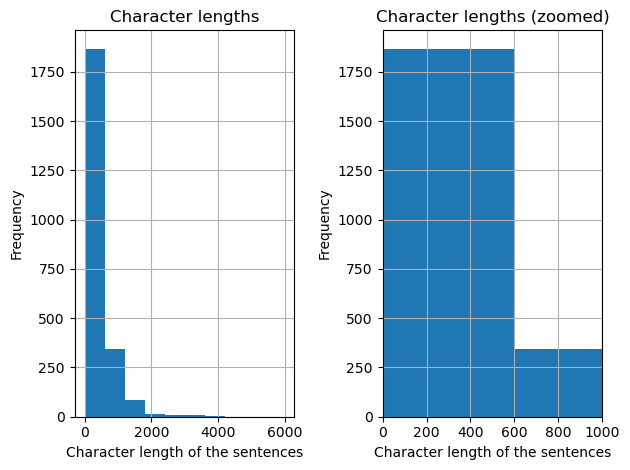

In [19]:
# Plot a histogram for that column
fig, axes = plt.subplots(1, 2)
df.hist(column="length", ax=axes[0])
axes[0].set_title('Character lengths')
axes[0].set(xlabel="Character length of the sentences", ylabel="Frequency")

df.hist(column="length", ax=axes[1])

axes[1].set_title('Character lengths (zoomed)')
axes[1].set(xlabel="Character length of the sentences", ylabel="Frequency", xlim = [0, 1000])
fig.tight_layout()

Define a cutoff for the sentences. All sentences belows this length will be removed

In [20]:
cut_len = 50

Create a smaller dataframe, and export it to csv, that only contains the short length sentences.
Check the csv and change the length condition accordingly.

In [21]:
# # Uncomment the following line of code to create the csv which contains the short length sentences.

# testing_df = df[df['length'] < cut_len]
# testing_df.to_csv(f"{year}_len_testing.csv", index=False)

<br>
Once, the length is decided, create a new dataframe with sentences greater that the length

In [22]:
df_reduced = df[ df["length"] > cut_len]
print("Length of the cleaned dataframe: ", df_reduced.shape[0])
print("Reduction of about {:.2f}%".format( (1 - df_reduced.shape[0]/df.shape[0]) * 100))

Length of the cleaned dataframe:  2063
Reduction of about 11.57%


In [23]:
df_reduced.reset_index(drop=True, inplace=True)
df_reduced.index.name = "index"

<br>

## E. Further Cleaning and Regex
Remove unecessary words in the sentences which do not contribute to the overall meaning.

In [24]:
# New dataframe so that the results of the matching can be compared
df_cleaned = df_reduced.copy()

# A new dictionary to keep track of the number of errors
errorsDict = {}

In [25]:
# Create a new column that will contain the removed words that match the section patter
df_cleaned['removed'] = np.nan

# Rename 'sentence' column to 'org_sent' to avoid confusion
df_cleaned.rename(columns={'sentence': 'org_sent'}, inplace=True)

In [26]:
df_cleaned.head()

,org_sent,length,start_page,end_page,removed
index,,,,,
0,"AUIS AND JOINT RESOLUTIONS OF THE GENERAL’ ASSEMBLY OF THE STATE OF SOUTH CAROLINA Passed at the Regular Session which was begun and held at the City of Columbia on the Twenty-Seventh Day of November, A. D. 1894, and was adjourned without day on the Twenty-Fourth Day of December, A. D. 1894.",294,049,049,NaN
1,"W. H. TIMMERMAN, Lieu- tenant-Governor and ez officio President of the Senate.",78,049,049,NaN
2,"Ira B. Jones, Speaker of the House of Representatives.",54,049,049,NaN
3,"J. WALTER Gray, Clerk of the House of Representatives.",54,049,049,NaN
4,"ea ee Compiled, prepared and indexed by Wm. C. Wore, Esq., Attorney-at-Law, appointed by Gov. JoaN Gary Evans, by virtue of the authority contained in the Legislative Per Diem and Appropriation Act of 1894.",206,049,049,NaN


In [27]:
def replaceInDF(rgx_match: re.Pattern, df: pd.DataFrame, prevAppend: bool):
    '''
    Find the provided regex pattern in the provided dataframe.
    
    Parameters
    ----------
    rgx_match : re.Pattern
        A regular expression pattern that will be search for and replaced in the df
    df: pandas.Dataframe
        A Pandas dataframe to search and replace for
        Should contain an:
            'org_sent' column, in which the matches which will be replaced
             'removed' column, in which the matched string will be stored
     prevAppend: bool
         A flag for whether the match should be append to the end of the previous sentence
        
    Returns
    -------
    A tuple consisting of:
    
    df: pandas.Dataframe
        The modified Dataframe with the matches performed
    errorCount: int
        A count of how many times this error was found.
    '''
    
    errorCount = 0
    
    for i in range(0, df.shape[0]):
    
        # The value at this row's "removed" column
        removed_val = df.iloc[i]['removed']
        
        # The found matches
        matches = "; ".join([x.group() for x in re.finditer(rgx_match, df.iloc[i]['org_sent'])])
        
        # if no match found...
        if not matches:
            continue

        # Else if match is found...
        
        # Update the counter for the error with the number of matches found
        errorCount += len(matches.split(";"))
        
        # Check if there is already a value in the 'removed' column for that row
        if removed_val != "" and not pd.isnull(removed_val):
            # Append the matches to the existing value seperated by ";"
            df.at[i, 'removed'] = str(removed_val) + "; " + matches
        else:
            # Add the matched patterns to the "removed" section seperated by ";"
            df.at[i, 'removed'] = matches
        
        if prevAppend and i != 0:
            
            m = re.search(rgx_match, df.iloc[i]['org_sent'])
            if m:
                # Add to the end of the previous sentence
                df.at[i-1, 'org_sent'] = df.iloc[i-1]['org_sent'] + " " + str(m.group())
            
        # Remove the matched patterns from sentences
        df.at[i, 'org_sent'] = re.sub(rgx_match, '', df.iloc[i]['org_sent'])    
        
    return df, errorCount

<br>

### 1. Removing section identifiers
The following code implements regex patterns to identify sections, such as "Section 1.", "Sec. 4.", etc. 
<br>Since most sections, which need to be removed, appear either at the start or the start of the ORCed sentence, the pattern finds matches either at the start or the end of the sentence.
<br>Do note that the same pattern is repeated for the start and end of the sentence, and is seperated by '|'.

Some notes about the pattern:
- `r'(S|s|E|e|C|c|T|t|I|i|O|o|N|n){2,}'` matches "Section"
- `r'(\.|,|:|;| )'{0,2}` matches mistaken delimiters or spaces following "Section"
- `r'[0Oo1Iil!2Z5S6G\d]{1,2}'` matches the section number. Letters are required in this pattern to account for OCR mistakes
- `r'(. |.| |)'` matches the end of phrase spaces and periods

In [28]:
rgx_match = re.compile(r"^(S|s|E|e|C|c|T|t|I|i|O|o|N|n){2,}(\.|,|:|;| ){0,2}[0Oo1Iil!2Z5S6G\d]{1,2}(. |.| |)|(S|s|E|e|C|c|T|t|I|i|O|o|N|n){2,}(\.|,|:|;| ){0,2}[0Oo1Iil!2Z5S6G\d]{1,2}(. |.| |)$")

df_cleaned, errorsDict['section identifiers'] = replaceInDF(rgx_match, df_cleaned, False)

In [29]:
df_cleaned.head(10)

,org_sent,length,start_page,end_page,removed
index,,,,,
0,"AUIS AND JOINT RESOLUTIONS OF THE GENERAL’ ASSEMBLY OF THE STATE OF SOUTH CAROLINA Passed at the Regular Session which was begun and held at the City of Columbia on the Twenty-Seventh Day of November, A. D. 1894, and was adjourned without day on the Twenty-Fourth Day of December, A. D. 1894.",294,049,049,NaN
1,"W. H. TIMMERMAN, Lieu- tenant-Governor and ez officio President of the Senate.",78,049,049,NaN
2,"Ira B. Jones, Speaker of the House of Representatives.",54,049,049,NaN
3,"J. WALTER Gray, Clerk of the House of Representatives.",54,049,049,NaN
4,"ea ee Compiled, prepared and indexed by Wm. C. Wore, Esq., Attorney-at-Law, appointed by Gov. JoaN Gary Evans, by virtue of the authority contained in the Legislative Per Diem and Appropriation Act of 1894.",206,049,049,NaN
5,AN ACT to Liwit aNp F1x THE NUMBER OF BalILirrs WHO SHALL BE APPOINTED BY THE SHERIFFS OF THIS STATE TO SERVE IN ATTENDANCE AT EACH TERM OF THE COURT OF ComMON PLEAS AND GENERAL SESSIONS FOR THEIR RE- SPECTIVE COU,219,049,049,NTIES.
6,"Be it enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in Gen- eral Assembly, and by the authority of the same, That from and after the passage of this Act the Sheriffs of this State shall.",245,049,050,NaN
7,not appoint more than five (5) baliffs to attend and serve at each term of the Court of Common Pleas and Gen- H eral Session for their respective Counties.,155,050,050,NaN
8,"Approved December 18th, A. D. 1894. AN ACT to AmMennD Section 6d oF AcT ENTITLED “AN ACT TO AMEND AN Act ENTITLED ‘AN AcT TO PROVIDE FOR THE RELIEF OF CERTAIN SOLDIERS, SAILORS, AND WIDOWS OF SOLDIERS OR SAILORS, OF THE LATE WAR BETWEEN THE a 99 States,’ APPROVED DECEMBER 24TH, 188 45 APPROVED DECEMBER 247TH, 1888. Be it enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in Gen- eral Assembly, and by the authority of the same, That Sec- tion Gd of an Act entitled “An Act to amend an Act entitled ‘An Act to provide for the relief of certain soldiers, sailors, and widows of soldiers and sailors, of the late war between the States,’ approved December 24th, 1887,” approved De- cember 24th, 1888, being Section 948 of the Revised Statutes of 1893, be amended by striking out the words “eight days,” wherever it occurs in said Sections, and insert in lieu thereof the words “two days;” also by striking out “three” before “dollars” and inserting “two.” So that said Sec- tions, when amended, shall read as follows: Section 6d.",1081,050,050,NaN


<br>

### 2. Removing end of line hyphenation
Whenever a word in the sentence continues from the end of a line to the beginning of the next line and is joined by a hyphen, the OCRed sentence also contains that hyphen and a space.
<br>For example, 'Commander-in-Chief' is OCRed as 'Com- mander-in-Chief'
<br>The following code implements regex patterns to remove "- " in the text since each hyphenated word is split with "- ".

In [30]:
rgx_match = re.compile('[-][ ]')
df_cleaned, errorsDict['EOL hyphenation'] = replaceInDF(rgx_match, df_cleaned, False)

In [31]:
df_cleaned.head(10)

,org_sent,length,start_page,end_page,removed
index,,,,,
0,"AUIS AND JOINT RESOLUTIONS OF THE GENERAL’ ASSEMBLY OF THE STATE OF SOUTH CAROLINA Passed at the Regular Session which was begun and held at the City of Columbia on the Twenty-Seventh Day of November, A. D. 1894, and was adjourned without day on the Twenty-Fourth Day of December, A. D. 1894.",294,049,049,NaN
1,"W. H. TIMMERMAN, Lieutenant-Governor and ez officio President of the Senate.",78,049,049,-
2,"Ira B. Jones, Speaker of the House of Representatives.",54,049,049,NaN
3,"J. WALTER Gray, Clerk of the House of Representatives.",54,049,049,NaN
4,"ea ee Compiled, prepared and indexed by Wm. C. Wore, Esq., Attorney-at-Law, appointed by Gov. JoaN Gary Evans, by virtue of the authority contained in the Legislative Per Diem and Appropriation Act of 1894.",206,049,049,NaN
5,AN ACT to Liwit aNp F1x THE NUMBER OF BalILirrs WHO SHALL BE APPOINTED BY THE SHERIFFS OF THIS STATE TO SERVE IN ATTENDANCE AT EACH TERM OF THE COURT OF ComMON PLEAS AND GENERAL SESSIONS FOR THEIR RESPECTIVE COU,219,049,049,NTIES.; -
6,"Be it enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That from and after the passage of this Act the Sheriffs of this State shall.",245,049,050,-
7,not appoint more than five (5) baliffs to attend and serve at each term of the Court of Common Pleas and GenH eral Session for their respective Counties.,155,050,050,-
8,"Approved December 18th, A. D. 1894. AN ACT to AmMennD Section 6d oF AcT ENTITLED “AN ACT TO AMEND AN Act ENTITLED ‘AN AcT TO PROVIDE FOR THE RELIEF OF CERTAIN SOLDIERS, SAILORS, AND WIDOWS OF SOLDIERS OR SAILORS, OF THE LATE WAR BETWEEN THE a 99 States,’ APPROVED DECEMBER 24TH, 188 45 APPROVED DECEMBER 247TH, 1888. Be it enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That Section Gd of an Act entitled “An Act to amend an Act entitled ‘An Act to provide for the relief of certain soldiers, sailors, and widows of soldiers and sailors, of the late war between the States,’ approved December 24th, 1887,” approved December 24th, 1888, being Section 948 of the Revised Statutes of 1893, be amended by striking out the words “eight days,” wherever it occurs in said Sections, and insert in lieu thereof the words “two days;” also by striking out “three” before “dollars” and inserting “two.” So that said Sections, when amended, shall read as follows: Section 6d.",1081,050,050,- ; - ; - ; -


<br>

### 3. Relocating incorrect "Approved ..." phrases
The “Approved…” phrases are incorrectly appended to the start of the next law. They should by appended to the end of the previous law.
<br>Phrases might be of the format: 
- "Approved the 2oth day of February, A. D. 1901",
- "Approved December 15th, A. D. 1892.",
- "Approved December O5th, A. D. 1892.",
- "Approved December !2th, A. D. 1892.",
- "Approved December 6Gth, A. D. 1892.",
- "Approved December 05th, A. D. 1892.",

Since phrases might either have the month or the date after the "Approved" sub-string, the code below utilized two patterns to account for either case, seperated by '|'.
<br>
Some notes about the pattern:
- `r'[0Oo1Iil!2Z5S6G\d]{1,2}'` matches the date. Letters are required in this pattern to account for OCR mistakes
- `r'(?:th|st|nd|rd)'` matches the prefixes for the dates
- `r'[A-Z][a-z]+'` matches the month
- `r'.{4}'` matches years
- `r'(. |.| |)'` matches the end of phrase spaces and periods

In [32]:
rgx_match = re.compile(
    r'^Approved the [0Oo1Iil!2Z5S6G\d]{1,2}(?:th|st|nd|rd) day of [A-Z][a-z]+, A\. D\. .{4}(. |.| |)\b|Approved [A-Z][a-z]+ [0Oo1Iil!2Z5S6G\d]{1,2}(?:th|st|nd|rd), A\. D\. .{4}(. |.| |)\b')
df_cleaned, errorsDict['Approved phrases'] = replaceInDF(rgx_match, df_cleaned, True)

In [33]:
df_cleaned.head(10)

,org_sent,length,start_page,end_page,removed
index,,,,,
0,"AUIS AND JOINT RESOLUTIONS OF THE GENERAL’ ASSEMBLY OF THE STATE OF SOUTH CAROLINA Passed at the Regular Session which was begun and held at the City of Columbia on the Twenty-Seventh Day of November, A. D. 1894, and was adjourned without day on the Twenty-Fourth Day of December, A. D. 1894.",294,049,049,NaN
1,"W. H. TIMMERMAN, Lieutenant-Governor and ez officio President of the Senate.",78,049,049,-
2,"Ira B. Jones, Speaker of the House of Representatives.",54,049,049,NaN
3,"J. WALTER Gray, Clerk of the House of Representatives.",54,049,049,NaN
4,"ea ee Compiled, prepared and indexed by Wm. C. Wore, Esq., Attorney-at-Law, appointed by Gov. JoaN Gary Evans, by virtue of the authority contained in the Legislative Per Diem and Appropriation Act of 1894.",206,049,049,NaN
5,AN ACT to Liwit aNp F1x THE NUMBER OF BalILirrs WHO SHALL BE APPOINTED BY THE SHERIFFS OF THIS STATE TO SERVE IN ATTENDANCE AT EACH TERM OF THE COURT OF ComMON PLEAS AND GENERAL SESSIONS FOR THEIR RESPECTIVE COU,219,049,049,NTIES.; -
6,"Be it enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That from and after the passage of this Act the Sheriffs of this State shall.",245,049,050,-
7,"not appoint more than five (5) baliffs to attend and serve at each term of the Court of Common Pleas and GenH eral Session for their respective Counties. Approved December 18th, A. D. 1894.",155,050,050,-
8,"AN ACT to AmMennD Section 6d oF AcT ENTITLED “AN ACT TO AMEND AN Act ENTITLED ‘AN AcT TO PROVIDE FOR THE RELIEF OF CERTAIN SOLDIERS, SAILORS, AND WIDOWS OF SOLDIERS OR SAILORS, OF THE LATE WAR BETWEEN THE a 99 States,’ APPROVED DECEMBER 24TH, 188 45 APPROVED DECEMBER 247TH, 1888. Be it enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That Section Gd of an Act entitled “An Act to amend an Act entitled ‘An Act to provide for the relief of certain soldiers, sailors, and widows of soldiers and sailors, of the late war between the States,’ approved December 24th, 1887,” approved December 24th, 1888, being Section 948 of the Revised Statutes of 1893, be amended by striking out the words “eight days,” wherever it occurs in said Sections, and insert in lieu thereof the words “two days;” also by striking out “three” before “dollars” and inserting “two.” So that said Sections, when amended, shall read as follows: Section 6d.",1081,050,050,"- ; - ; - ; - ; Approved December 18th, A. D. 1894."


<br>

### 4. Removing Act seperators
The horizontal lines differentiating one Act from another show up as U+2014 : EM DASH characters (one or multiple) in the OCR.
<br>For example, '——- —— AN ACT...' or '—— AN ACT...'

Some notes about the pattern:
- `r'^—+'` matches one or more consecutive occurrences of the "—" character at the start of a line.
- `r'(?=\s*[A-Za-z])'` is a positive lookahead (this part isn't captured) that checks if there is zero or more whitespace characters (\s*) followed by a letter ([A-Za-z]) after the "—" characters.

In [34]:
rgx_match = re.compile(r'^—+(?=\s*[A-Za-z])')
df_cleaned, errorsDict['Act seperators'] = replaceInDF(rgx_match, df_cleaned, False)

In [35]:
df_cleaned.head()

,org_sent,length,start_page,end_page,removed
index,,,,,
0,"AUIS AND JOINT RESOLUTIONS OF THE GENERAL’ ASSEMBLY OF THE STATE OF SOUTH CAROLINA Passed at the Regular Session which was begun and held at the City of Columbia on the Twenty-Seventh Day of November, A. D. 1894, and was adjourned without day on the Twenty-Fourth Day of December, A. D. 1894.",294,049,049,NaN
1,"W. H. TIMMERMAN, Lieutenant-Governor and ez officio President of the Senate.",78,049,049,-
2,"Ira B. Jones, Speaker of the House of Representatives.",54,049,049,NaN
3,"J. WALTER Gray, Clerk of the House of Representatives.",54,049,049,NaN
4,"ea ee Compiled, prepared and indexed by Wm. C. Wore, Esq., Attorney-at-Law, appointed by Gov. JoaN Gary Evans, by virtue of the authority contained in the Legislative Per Diem and Appropriation Act of 1894.",206,049,049,NaN


<br>

### 5. Removing incorrect numbers at the start
Some numbers are incorrectly left at the start of the sentence from the OCR process. They are rather OCRed, for example, as 2, or 2.

Some notes about the pattern:
- `r'^[0Oo1Iil!2Z5S6G\d]{1,3}'` matches upto 3 numbers at the start of the string
- `r'(. |.| |)'` matches the end of phrase spaces and periods

In [36]:
rgx_match = re.compile(r'^[0Oo1Iil!2Z5S6G\d]{1,3}(. |.| |)')
df_cleaned, errorsDict['Incorrect starting nums'] = replaceInDF(rgx_match, df_cleaned, False)

In [37]:
df_cleaned.head()

,org_sent,length,start_page,end_page,removed
index,,,,,
0,"AUIS AND JOINT RESOLUTIONS OF THE GENERAL’ ASSEMBLY OF THE STATE OF SOUTH CAROLINA Passed at the Regular Session which was begun and held at the City of Columbia on the Twenty-Seventh Day of November, A. D. 1894, and was adjourned without day on the Twenty-Fourth Day of December, A. D. 1894.",294,049,049,NaN
1,"W. H. TIMMERMAN, Lieutenant-Governor and ez officio President of the Senate.",78,049,049,-
2,"a B. Jones, Speaker of the House of Representatives.",54,049,049,Ir
3,"J. WALTER Gray, Clerk of the House of Representatives.",54,049,049,NaN
4,"ea ee Compiled, prepared and indexed by Wm. C. Wore, Esq., Attorney-at-Law, appointed by Gov. JoaN Gary Evans, by virtue of the authority contained in the Legislative Per Diem and Appropriation Act of 1894.",206,049,049,NaN


<br>

### 6. Removing session headers
For some volumes, the OCRed text includes information about the session held (which is usually found on the first page).
<br>The first valid sentence starts with "An Acts ...". So, to remove them, the code removes all sentences until the first valid sentence appears

In [38]:
disregarded = 0  # Count for the number removed

for i, sent in enumerate(df_cleaned['org_sent']):

    # If the sentence with "an" is found, exit the loop
    if sent.lower().strip().startswith("an"):
           break
    
    # Disregard the sentence since it does not start with "an"
    df_cleaned.drop(index=i, inplace=True)
    disregarded += 1

In [39]:
# Reset the index
df_cleaned.reset_index(drop=True, inplace=True)

In [40]:
print(f"Total number of sentences changed to disregarded: {disregarded}.")
errorsDict['Session headers'] = disregarded

Total number of sentences changed to disregarded: 5.


In [41]:
df_cleaned.head()

,org_sent,length,start_page,end_page,removed
0,AN ACT to Liwit aNp F1x THE NUMBER OF BalILirrs WHO SHALL BE APPOINTED BY THE SHERIFFS OF THIS STATE TO SERVE IN ATTENDANCE AT EACH TERM OF THE COURT OF ComMON PLEAS AND GENERAL SESSIONS FOR THEIR RESPECTIVE COU,219,049,049,NTIES.; -
1,"Be it enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That from and after the passage of this Act the Sheriffs of this State shall.",245,049,050,-
2,"not appoint more than five (5) baliffs to attend and serve at each term of the Court of Common Pleas and GenH eral Session for their respective Counties. Approved December 18th, A. D. 1894.",155,050,050,-
3,"AN ACT to AmMennD Section 6d oF AcT ENTITLED “AN ACT TO AMEND AN Act ENTITLED ‘AN AcT TO PROVIDE FOR THE RELIEF OF CERTAIN SOLDIERS, SAILORS, AND WIDOWS OF SOLDIERS OR SAILORS, OF THE LATE WAR BETWEEN THE a 99 States,’ APPROVED DECEMBER 24TH, 188 45 APPROVED DECEMBER 247TH, 1888. Be it enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That Section Gd of an Act entitled “An Act to amend an Act entitled ‘An Act to provide for the relief of certain soldiers, sailors, and widows of soldiers and sailors, of the late war between the States,’ approved December 24th, 1887,” approved December 24th, 1888, being Section 948 of the Revised Statutes of 1893, be amended by striking out the words “eight days,” wherever it occurs in said Sections, and insert in lieu thereof the words “two days;” also by striking out “three” before “dollars” and inserting “two.” So that said Sections, when amended, shall read as follows: Section 6d.",1081,050,050,"- ; - ; - ; - ; Approved December 18th, A. D. 1894."
4,"The members of each County Examining Board of Pensioners shall receive for their services under this Act the sum of two dollars per day: Provided, That the number of days on which they are engaged in such work shall not exceed two days, and such per diem shall be paid by the State Treasurer upon the warrant of the Comptroller-General, out of the appropriations for the pensions provided for herein. Approved December 17th, A. D. 1894.",402,050,050,-


<br>

### 7. Converting to uppercase
For some sentence, the OCR process outputs few words as a mix of upper and lower case letters. To help in producing human readable digitized text, the following piece of code detects and changes words to all uppercase.
<br>While this step might not be a priority for computational analysis, it is an important step to help improve the readability of the sentences
<br>An example, "AN ACT FoR THE PROTECTION OF THE AIDS TO NAVIGATION EsTABLISHED BY THE AUTHORITY OF THE UNITED STATES LicgHt Hovust BoarD WITHIN THE STATE OF SOUTH CAROLINA."

In [42]:
def upperIfNeeded(sentence, ratio = 0.50):
    '''
    Convert the given sentence list into an uppercase sentence list
    if the ratio of uppercase words (not including the ones with a mix of digits 
    or words like "SECTION") to the total words is greater than a fixed value.
    
    Parameters
    ----------
    sentence: str
         A str of sentence to check and convert to uppercase
        
    Returns
    -------
    sentence: str
        If check is approved the return an uppercase version of str.
        Else return the sentence.
    '''
    
    count = 0  # A count of the number of already uppercased words
    
    for word in sentence.split(" "):
        # Check whether the word consists of only letters,
        # has a length greater than 1, is uppercase, and 
        # isn't "SECTION"
        if word.isalpha() and len(word) > 1 and word.isupper() and word != "SECTION":
            count += 1

    # If the count to words ratio is greater
    if (count/len(sentence.split(" ")) > ratio):
        # Return all uppercase words
        return sentence.upper()        
    
    # Else, return the original sentence list
    return sentence

In [43]:
# Apply the above function to each sentence in 'org_sent'
# And store the output a new column named 'modified'
df_cleaned['modified'] = df_cleaned.apply(lambda x: upperIfNeeded(x['org_sent']), axis=1)

In [44]:
# Check if the original sentence has been converted to uppercase,
# and if it has, then add a boolean in a new column named 'flag'

df_cleaned['flag'] = np.where(df_cleaned['org_sent'] != df_cleaned['modified'], True, False)

In [45]:
# View the rows where the sentence has been converted to uppercase
df_cleaned[df_cleaned['flag'] == True]

,org_sent,length,start_page,end_page,removed,modified,flag
0,AN ACT to Liwit aNp F1x THE NUMBER OF BalILirrs WHO SHALL BE APPOINTED BY THE SHERIFFS OF THIS STATE TO SERVE IN ATTENDANCE AT EACH TERM OF THE COURT OF ComMON PLEAS AND GENERAL SESSIONS FOR THEIR RESPECTIVE COU,219,049,049,NTIES.; -,AN ACT TO LIWIT ANP F1X THE NUMBER OF BALILIRRS WHO SHALL BE APPOINTED BY THE SHERIFFS OF THIS STATE TO SERVE IN ATTENDANCE AT EACH TERM OF THE COURT OF COMMON PLEAS AND GENERAL SESSIONS FOR THEIR RESPECTIVE COU,True
7,"AN ACT TO AMEND SECTION 274 OF THE GENERAL STATUTES, Berne SEcTION 320 OF THE REVISED STATUTES, VOL. I., RELATING TO CouNnTY TREASURERS’ COMM",185,051,051,"ISSIONS.; Approved December 17th, A. D. 1894.","AN ACT TO AMEND SECTION 274 OF THE GENERAL STATUTES, BERNE SECTION 320 OF THE REVISED STATUTES, VOL. I., RELATING TO COUNNTY TREASURERS’ COMM",True
11,"AN ACT to PrescrIBE AN ADDITIONAL OATH OF OFFICE FOR Series, Deputy SHERIFFS, CONSTABLES, PoLicE OFFICERS, MARSHALS, AND OTHER PEACE OFFICERS.",180,052,052,"- ; Approved December 17th, A. D. 1894.","AN ACT TO PRESCRIBE AN ADDITIONAL OATH OF OFFICE FOR SERIES, DEPUTY SHERIFFS, CONSTABLES, POLICE OFFICERS, MARSHALS, AND OTHER PEACE OFFICERS.",True
15,"AN ACT To AMEND SECTION EIGHTEEN OF THE Cone or CIVIL PROCEDURE OF SOUTH CAROLINA, RELATING TO THE TIME oF HoLpING THE CircuIT Courts IN THE First Circvlt.",191,053,053,"Approved December 21st, A. D. 1894.","AN ACT TO AMEND SECTION EIGHTEEN OF THE CONE OR CIVIL PROCEDURE OF SOUTH CAROLINA, RELATING TO THE TIME OF HOLPING THE CIRCUIT COURTS IN THE FIRST CIRCVLT.",True
19,"AN ACT TO AMEND SECTION 2236 OF THE GENERAL STATUTES oF 1882 as HERETOFORE AMENDED (APPEARING AS SECTION 2375 IN THE REVISED STATUTES OF 1893), RELATING TO THE PREPARATION OF Lists oF INHABITANTS TO SERVE AS JURORS.",220,053,053,- ; ——,"AN ACT TO AMEND SECTION 2236 OF THE GENERAL STATUTES OF 1882 AS HERETOFORE AMENDED (APPEARING AS SECTION 2375 IN THE REVISED STATUTES OF 1893), RELATING TO THE PREPARATION OF LISTS OF INHABITANTS TO SERVE AS JURORS.",True
...,...,...,...,...,...,...,...
1972,"Approved December 22d, A. D. 1894. AN ACT To REDUCE THE LICENSE FEE FOR TRAFFIC IN SEED CoTron To $25.00 IN CLARENDON CoUNTY.",125,461,461,NaN,"APPROVED DECEMBER 22D, A. D. 1894. AN ACT TO REDUCE THE LICENSE FEE FOR TRAFFIC IN SEED COTRON TO $25.00 IN CLARENDON COUNTY.",True
1994,"Approved December 22d, A. D. 1894. AN ACT To AMEND AN Act ENTITLED “‘AN ACT TO AMEND THE CHARTER OF THE TOWN OF SUMMERVILLE,” APPROVED DECEMBER 22ND, A.",152,465,465,NaN,"APPROVED DECEMBER 22D, A. D. 1894. AN ACT TO AMEND AN ACT ENTITLED “‘AN ACT TO AMEND THE CHARTER OF THE TOWN OF SUMMERVILLE,” APPROVED DECEMBER 22ND, A.",True
2020,AN ACT To REpDucE THE NUMBER OF TRIAL JUSTICES FOR ABBEVILLE County.,104,469,469,"Approved December 24th, A. D. 1894.",AN ACT TO REPDUCE THE NUMBER OF TRIAL JUSTICES FOR ABBEVILLE COUNTY.,True
2023,AN ACT To INCORPORATE THE CITY OF ABBEVILLE.,80,469,470,"Approved January 5th, A. D. 1895.",AN ACT TO INCORPORATE THE CITY OF ABBEVILLE.,True


<b>Note:</b> If the above table is empty, it might help in decreasing the ratio parameter in `upperIfNeeded` above.

In [46]:
if not df_cleaned[df_cleaned['flag'] == True].empty:
    uppercased = df_cleaned['flag'].value_counts()[True]
else:
    uppercased = 0
print(f"Total number of sentences changed to uppercase: {uppercased}.")

errorsDict['Uppercased'] = uppercased

Total number of sentences changed to uppercase: 173.


If you are satisfied with the result and number of the uppercase changes, then replace the 'org_sent' with the 'modified' column and remove the 'flag' column.

In [47]:
df_cleaned.drop(['org_sent', 'flag'], axis=1, inplace=True)
df_cleaned.rename(columns={'modified': 'org_sent'}, inplace=True)

In [48]:
# Rearrange columns
cols = df_cleaned.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_cleaned = df_cleaned[cols]

Otherwise, you can change the ratio parameter in `upperIfNeeded` function to either increase the number (if you think sentences which shouldn't be uppercased are being uppercased) or decrease (if you think more sentences could be uppercased).

<br>
<br>
<b>Note:</b> The error fixing above is not perfect and some errors are still present in the dataframe after performing these operations.
Also, some errors are too random to match and search using a pattern, and are still present in the dataframe.
<br>The output below shows the number of errors corrected for this volume:

In [49]:
errorsDict

{'section identifiers': 879,
 'EOL hyphenation': 3112,
 'Approved phrases': 203,
 'Act seperators': 6,
 'Incorrect starting nums': 269,
 'Session headers': 5,
 'Uppercased': 173}

<br>

## F. Adding features
The features added below are:
- an id: a concatenation of the year and index number
- whether the sentence is an Act or a Joint
- the state that the law originates from

### 1. Adding ID

In [50]:
def addPrefix(fileName: str, nameLen: int, fileType: bool) -> str:
    '''
    Since the fileNames from the excel parsing could be any of any length
    (ranging from 1-3), this function appends a string of 0's to the 
    start of the input so that it is the specified nameLen lengths long.
    
    Parameters
    ----------
    fileName : str
        The file name that needs to be prefixed
    nameLen : int
        The length of the expected name of the file
        Ex. '00034.jpg' would have length of 5
        so nameLen should be 5
    fileType: bool
        True if the fileName contains a fileType prefix such as '.tiff'

    Returns
    -------
    str
        A length 5 file name (prefixed with 0's)
    '''
    
    # Remove the file type
    if fileType:
        name = fileName.split(".")[0]
    else:
        name = fileName

    prefix_length = nameLen - len(name)
    prefix = "0" * prefix_length
    
    final_string = prefix + fileName
    return final_string

In [51]:
df_cleaned.reset_index(inplace=True)
df_cleaned.rename(columns={"index" : "id"}, inplace=True)
# df_cleaned.set_index('id', inplace=True)

In [52]:
# The length of the id of the last row in the dataframe, which is used to assess how many 0's will be prefixed to the other ids
maxNumLength = len(str(df_cleaned.last_valid_index()))

for i in range(0, df_cleaned.shape[0]):
    df_cleaned.at[i, 'id'] = str(year) + "_" + addPrefix(str(df_cleaned.iloc[i]['id']), maxNumLength, fileType=False)

In [53]:
df_cleaned

,id,org_sent,length,start_page,end_page,removed
0,1894_0000,AN ACT TO LIWIT ANP F1X THE NUMBER OF BALILIRRS WHO SHALL BE APPOINTED BY THE SHERIFFS OF THIS STATE TO SERVE IN ATTENDANCE AT EACH TERM OF THE COURT OF COMMON PLEAS AND GENERAL SESSIONS FOR THEIR RESPECTIVE COU,219,049,049,NTIES.; -
1,1894_0001,"Be it enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That from and after the passage of this Act the Sheriffs of this State shall.",245,049,050,-
2,1894_0002,"not appoint more than five (5) baliffs to attend and serve at each term of the Court of Common Pleas and GenH eral Session for their respective Counties. Approved December 18th, A. D. 1894.",155,050,050,-
3,1894_0003,"AN ACT to AmMennD Section 6d oF AcT ENTITLED “AN ACT TO AMEND AN Act ENTITLED ‘AN AcT TO PROVIDE FOR THE RELIEF OF CERTAIN SOLDIERS, SAILORS, AND WIDOWS OF SOLDIERS OR SAILORS, OF THE LATE WAR BETWEEN THE a 99 States,’ APPROVED DECEMBER 24TH, 188 45 APPROVED DECEMBER 247TH, 1888. Be it enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That Section Gd of an Act entitled “An Act to amend an Act entitled ‘An Act to provide for the relief of certain soldiers, sailors, and widows of soldiers and sailors, of the late war between the States,’ approved December 24th, 1887,” approved December 24th, 1888, being Section 948 of the Revised Statutes of 1893, be amended by striking out the words “eight days,” wherever it occurs in said Sections, and insert in lieu thereof the words “two days;” also by striking out “three” before “dollars” and inserting “two.” So that said Sections, when amended, shall read as follows: Section 6d.",1081,050,050,"- ; - ; - ; - ; Approved December 18th, A. D. 1894."
4,1894_0004,"The members of each County Examining Board of Pensioners shall receive for their services under this Act the sum of two dollars per day: Provided, That the number of days on which they are engaged in such work shall not exceed two days, and such per diem shall be paid by the State Treasurer upon the warrant of the Comptroller-General, out of the appropriations for the pensions provided for herein. Approved December 17th, A. D. 1894.",402,050,050,-
...,...,...,...,...,...,...
2053,1894_2053,But no such grant shall be made for a longer period than thirty years.,70,479,479,NaN
2054,1894_2054,"That this Act shall take effect from and after its passage; that all other Acts conferring powers on the town of Abbeville, and not herein referred to nor inconsistent with this Act, are continued of full force; that the ordihances of the town of Abbeville are hereby continued, to be of full force and effect for the government of the city of Abbeville until repealed or modified by other ordinances by the City Council; all the obligations and contracts of the town of Abbeville and to the town of Abbeville are hereby continued as the valid and subsisting obligations and contracts of and to the city of Abbeville; and all the property of the town of Abbeville is hereby vested in the citv of Abbeville.",721,479,479,Sec. 13. ; - ; - ; -
2055,1894_2055,"That this Act is a public Act, and shall continue of foree for thirty years next hereafter; and all Acts or parts of Acts inconsistent with this Act are hereby repealed.",180,479,479,Sec. 14. ; -
2056,1894_2056,A JOINT RESOLUTION TO PRROVIPE FOR LOCATING THE BOUNDARY LINE BETWEEN SPARTANBURG AND GREENVILLE COUNTIES AT AND NEAR PELHAM FACTORY.,135,479,479,-


<br>

### 2. Adding the remaining identifiers

In [54]:
df_cleaned.insert(1, 'law_type', 'Acts')
df_cleaned.insert(2, 'state', 'SOUTH CAROLINA')

In [55]:
df_cleaned

,id,law_type,state,org_sent,length,start_page,end_page,removed
0,1894_0000,Acts,SOUTH CAROLINA,AN ACT TO LIWIT ANP F1X THE NUMBER OF BALILIRRS WHO SHALL BE APPOINTED BY THE SHERIFFS OF THIS STATE TO SERVE IN ATTENDANCE AT EACH TERM OF THE COURT OF COMMON PLEAS AND GENERAL SESSIONS FOR THEIR RESPECTIVE COU,219,049,049,NTIES.; -
1,1894_0001,Acts,SOUTH CAROLINA,"Be it enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That from and after the passage of this Act the Sheriffs of this State shall.",245,049,050,-
2,1894_0002,Acts,SOUTH CAROLINA,"not appoint more than five (5) baliffs to attend and serve at each term of the Court of Common Pleas and GenH eral Session for their respective Counties. Approved December 18th, A. D. 1894.",155,050,050,-
3,1894_0003,Acts,SOUTH CAROLINA,"AN ACT to AmMennD Section 6d oF AcT ENTITLED “AN ACT TO AMEND AN Act ENTITLED ‘AN AcT TO PROVIDE FOR THE RELIEF OF CERTAIN SOLDIERS, SAILORS, AND WIDOWS OF SOLDIERS OR SAILORS, OF THE LATE WAR BETWEEN THE a 99 States,’ APPROVED DECEMBER 24TH, 188 45 APPROVED DECEMBER 247TH, 1888. Be it enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That Section Gd of an Act entitled “An Act to amend an Act entitled ‘An Act to provide for the relief of certain soldiers, sailors, and widows of soldiers and sailors, of the late war between the States,’ approved December 24th, 1887,” approved December 24th, 1888, being Section 948 of the Revised Statutes of 1893, be amended by striking out the words “eight days,” wherever it occurs in said Sections, and insert in lieu thereof the words “two days;” also by striking out “three” before “dollars” and inserting “two.” So that said Sections, when amended, shall read as follows: Section 6d.",1081,050,050,"- ; - ; - ; - ; Approved December 18th, A. D. 1894."
4,1894_0004,Acts,SOUTH CAROLINA,"The members of each County Examining Board of Pensioners shall receive for their services under this Act the sum of two dollars per day: Provided, That the number of days on which they are engaged in such work shall not exceed two days, and such per diem shall be paid by the State Treasurer upon the warrant of the Comptroller-General, out of the appropriations for the pensions provided for herein. Approved December 17th, A. D. 1894.",402,050,050,-
...,...,...,...,...,...,...,...,...
2053,1894_2053,Acts,SOUTH CAROLINA,But no such grant shall be made for a longer period than thirty years.,70,479,479,NaN
2054,1894_2054,Acts,SOUTH CAROLINA,"That this Act shall take effect from and after its passage; that all other Acts conferring powers on the town of Abbeville, and not herein referred to nor inconsistent with this Act, are continued of full force; that the ordihances of the town of Abbeville are hereby continued, to be of full force and effect for the government of the city of Abbeville until repealed or modified by other ordinances by the City Council; all the obligations and contracts of the town of Abbeville and to the town of Abbeville are hereby continued as the valid and subsisting obligations and contracts of and to the city of Abbeville; and all the property of the town of Abbeville is hereby vested in the citv of Abbeville.",721,479,479,Sec. 13. ; - ; - ; -
2055,1894_2055,Acts,SOUTH CAROLINA,"That this Act is a public Act, and shall continue of foree for thirty years next hereafter; and all Acts or parts of Acts inconsistent with this Act are hereby repealed.",180,479,479,Sec. 14. ; -
2056,1894_2056,Acts,SOUTH CAROLINA,A JOINT RESOLUTION TO PRROVIPE FOR LOCATING THE BOUNDARY LINE BETWEEN SPARTANBURG AND GREENVILLE COUNTIES AT AND NEAR PELHAM FACTORY.,135,479,479,-


<br>

## Exporting

In [56]:
# Drop the 'removed' column
df_cleaned.drop(['removed'], axis = 1, inplace=True)

# Rename the 'org_sent' column
df_cleaned.rename(columns={"org_sent": "sentence"}, inplace=True)

df_cleaned

,id,law_type,state,sentence,length,start_page,end_page
0,1894_0000,Acts,SOUTH CAROLINA,AN ACT TO LIWIT ANP F1X THE NUMBER OF BALILIRRS WHO SHALL BE APPOINTED BY THE SHERIFFS OF THIS STATE TO SERVE IN ATTENDANCE AT EACH TERM OF THE COURT OF COMMON PLEAS AND GENERAL SESSIONS FOR THEIR RESPECTIVE COU,219,049,049
1,1894_0001,Acts,SOUTH CAROLINA,"Be it enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That from and after the passage of this Act the Sheriffs of this State shall.",245,049,050
2,1894_0002,Acts,SOUTH CAROLINA,"not appoint more than five (5) baliffs to attend and serve at each term of the Court of Common Pleas and GenH eral Session for their respective Counties. Approved December 18th, A. D. 1894.",155,050,050
3,1894_0003,Acts,SOUTH CAROLINA,"AN ACT to AmMennD Section 6d oF AcT ENTITLED “AN ACT TO AMEND AN Act ENTITLED ‘AN AcT TO PROVIDE FOR THE RELIEF OF CERTAIN SOLDIERS, SAILORS, AND WIDOWS OF SOLDIERS OR SAILORS, OF THE LATE WAR BETWEEN THE a 99 States,’ APPROVED DECEMBER 24TH, 188 45 APPROVED DECEMBER 247TH, 1888. Be it enacted by the Senate and House of Representatives of the State of South Carolina, now met and sitting in General Assembly, and by the authority of the same, That Section Gd of an Act entitled “An Act to amend an Act entitled ‘An Act to provide for the relief of certain soldiers, sailors, and widows of soldiers and sailors, of the late war between the States,’ approved December 24th, 1887,” approved December 24th, 1888, being Section 948 of the Revised Statutes of 1893, be amended by striking out the words “eight days,” wherever it occurs in said Sections, and insert in lieu thereof the words “two days;” also by striking out “three” before “dollars” and inserting “two.” So that said Sections, when amended, shall read as follows: Section 6d.",1081,050,050
4,1894_0004,Acts,SOUTH CAROLINA,"The members of each County Examining Board of Pensioners shall receive for their services under this Act the sum of two dollars per day: Provided, That the number of days on which they are engaged in such work shall not exceed two days, and such per diem shall be paid by the State Treasurer upon the warrant of the Comptroller-General, out of the appropriations for the pensions provided for herein. Approved December 17th, A. D. 1894.",402,050,050
...,...,...,...,...,...,...,...
2053,1894_2053,Acts,SOUTH CAROLINA,But no such grant shall be made for a longer period than thirty years.,70,479,479
2054,1894_2054,Acts,SOUTH CAROLINA,"That this Act shall take effect from and after its passage; that all other Acts conferring powers on the town of Abbeville, and not herein referred to nor inconsistent with this Act, are continued of full force; that the ordihances of the town of Abbeville are hereby continued, to be of full force and effect for the government of the city of Abbeville until repealed or modified by other ordinances by the City Council; all the obligations and contracts of the town of Abbeville and to the town of Abbeville are hereby continued as the valid and subsisting obligations and contracts of and to the city of Abbeville; and all the property of the town of Abbeville is hereby vested in the citv of Abbeville.",721,479,479
2055,1894_2055,Acts,SOUTH CAROLINA,"That this Act is a public Act, and shall continue of foree for thirty years next hereafter; and all Acts or parts of Acts inconsistent with this Act are hereby repealed.",180,479,479
2056,1894_2056,Acts,SOUTH CAROLINA,A JOINT RESOLUTION TO PRROVIPE FOR LOCATING THE BOUNDARY LINE BETWEEN SPARTANBURG AND GREENVILLE COUNTIES AT AND NEAR PELHAM FACTORY.,135,479,479


In [57]:
# Export the final dataframe to csv for viewing
# df_cleaned.to_csv(f"{year}.csv", index=False)